In [15]:
import numpy as np
import pandas as pd

In [16]:
train_df = pd.read_csv("review_train.csv")

In [17]:
test_df = pd.read_csv("review_test.csv")

In [18]:
train_df.columns.difference(test_df.columns)

Index([], dtype='object')

In [19]:
train_df.shape

(14825, 3)

In [20]:
test_df.shape

(3707, 3)

In [21]:
train_df["Source"] = "train"
test_df["Source"] = "test"

In [22]:
train_df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [23]:
test_df.columns

Index(['Text', 'Score', 'Sentiment', 'Source'], dtype='object')

In [24]:
df = pd.concat([train_df, test_df])

In [25]:
df.shape

(18532, 4)

In [26]:
df.head()

,Text,Score,Sentiment,Source
0,"I got a free sample of these once, and now--we...",5,1,train
1,I used to get this Tea when I lived in Washing...,4,1,train
2,This is my all time favorite 'grab and go' sna...,5,1,train
3,This flavor is very good and unexpected. The ...,4,1,train
4,thrilled to have this assortment as i got the ...,4,1,train


In [27]:
df.tail()

,Text,Score,Sentiment,Source
3702,I always have Powerade in the house - for ever...,5,1,test
3703,I tried this coffee on a half dozen quests thi...,5,1,test
3704,The Neccos were exactly what I expected and fr...,5,1,test
3705,I thought I was doing the right thing by getti...,1,0,test
3706,Cugino's chicken noodle soup is pretty tasty. ...,5,1,test


Ref: Noor's notes on EDA, Preprocessing, NLP Preprocessing, Text Pre-processor

# EDA

In [31]:
df.Score.value_counts()

5    12795
4     2842
1     1866
2     1029
Name: Score, dtype: int64

In [32]:
df.Sentiment.value_counts()

1    15637
0     2895
Name: Sentiment, dtype: int64

In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Score,18532.0,4.277304,1.319827,1.0,4.0,5.0,5.0,5.0
Sentiment,18532.0,0.843784,0.363070,0.0,1.0,1.0,1.0,1.0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18532 entries, 0 to 3706
Data columns (total 4 columns):
Text         18532 non-null object
Score        18532 non-null int64
Sentiment    18532 non-null int64
Source       18532 non-null object
dtypes: int64(2), object(2)
memory usage: 723.9+ KB


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
import seaborn as sns

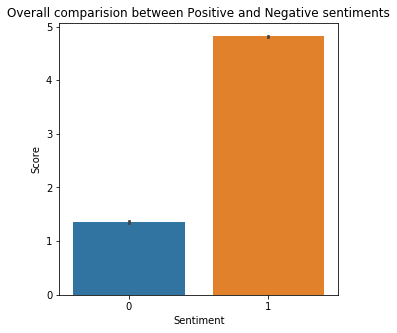

In [55]:
plt.figure(figsize=(5,5))
plt.title("Overall comparision between Positive and Negative sentiments")
sns.barplot(x=df.Sentiment, y=df['Score'])
plt.ylabel("Arrival delay (in minutes)")